In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import cv2
import math
import os, random
from imageio import imread, imwrite
import time
%matplotlib inline
s=np.seterr(divide='ignore', invalid='ignore')

# 1. Direct Linear Transform

In [2]:
#choose n points in the objects and corresponding image points
n=20
scale=28
def world_image_points(scale=28):
    world_points=[]
    for i in range(1,8):
        world_points.append([scale*i,0,0])
        world_points.append([0,scale*i,0])
        world_points.append([0,0,scale*i])
    image_points=[[1664,1614],[1546,1763],[1410,1608],
           [1795,1629],[1546,1931],[1281,1624],
           [1932,1647],[1545,2089],[1134,1642],
           [2083,1666],[1543,2251],[ 975,1660],
           [2247,1687],[1544,2403],[ 801,1678],
           [2421,1710],[1545,2557],[619,1702],
           [2619,1733],[1545,2706]]

    return np.array(world_points[:-1]),np.array(image_points)


Get world and image points in the image calib-object-legend.jpg . world points are noted based on the scale provided.


In [3]:
world,image= world_image_points(scale=2800)
# print(world)
# print(image)

## Camera Calibration

Construct G matrix using the given world and image coordinates. We get two equations for each world and its corresponding image point. Solve GP=0 for P and reshape the resultant vector into 3 by 4 matrix. 


In [4]:
def calculate_error(world,P,image):
    size=world.shape[0]
    homogeneous_world=np.concatenate((world.T, np.ones((1,size))),axis=0)
    
    image_coord = np.dot(P,homogeneous_world) # projected_points = P * world_points
    image_coord=(image_coord/image_coord[2:]) 
    image_coord=(image_coord[0:2]).T
    
    image=image[:,0:2]
    
    # Mean squared error
    error = np.mean(np.sqrt(np.sum((image_coord-image)**2,1)))
    return error

def projection_matrix(w,u):
    G =[]
    for i in range(w.shape[0]):
        temp = [w[i][0],w[i][1],w[i][2],1,0,0,0,0,-1*w[i][0]*u[i][0],-1*w[i][1]*u[i][0],-1*w[i][2]*u[i][0],-1*u[i][0]]
        temp2 = [0,0,0,0,w[i][0],w[i][1],w[i][2],1,-1*w[i][0]*u[i][1],-1*w[i][1]*u[i][1],-1*w[i][2]*u[i][1],-1*u[i][1]]
        G.append(temp)
        G.append(temp2)
    
    P = np.linalg.svd(G)[2][-1]
    P = P.reshape(3,4)
    e=calculate_error(w,P,u)
    
    return P,e

def calibration(world,image,normalization=False,denormalize=False):
    P=0
    error=0
    if normalization:
        P,error=normalized_projection_matrix(world,image,denormalize)
    else:
        P,error=projection_matrix(world,image)
        
    #K,R,C = decompose(P)
      
    return P,error 



## Normalization

Normalizing transformation T for image and U for world points are calculated by finding average coordinates (mean) X̄,Ȳ,Z̄  and average length d. T is used to normalize image points and U is used to normalize world points. Using SVD we get the projection matrix P, using the normalized points. To get projection matrix for unnormalized coordinates we have to denormalize the matrix by pre-multiplying P with inv(T) and post- multiply result with U.

In [5]:
def mean_dist(coord):
    size=coord.shape[0]
    mean = np.mean(coord,0)
    d=(np.sum((np.sqrt(np.sum((coord-mean)**2,1))),0))/size
    return mean,d

def normalized_projection_matrix(world,image,denormalize):
    size=world.shape[0]
    homo_image = np.hstack((image,np.ones((size,1)))).T#np.concatenate((image.T, np.ones((1,size))),axis=0)
    homo_world = np.hstack((world,np.ones((size,1)))).T#np.concatenate((world.T, np.ones((1,size))),axis=0)
    
    mean,d= mean_dist(world)
    r3=math.sqrt(3)/d
    
    U = [[r3,0,0,-1*r3*mean[0]],[0,r3,0,-1*r3*mean[1]],[0,0,r3,-1*r3*mean[2]],[0,0,0,1]]
    
    world_norm = np.dot(U,homo_world)[0:3,:].T

    mean,d= mean_dist(image)
    r2=math.sqrt(2)/d
    
    T = [[r2,0,-1*r2*mean[0]],[0,r2,-1*r2*mean[1]],[0,0,1]]
    inv_T = np.linalg.pinv(T)
    
    image_norm = np.dot(T,homo_image)[0:3,:].T
    
    P,e = projection_matrix(world_norm,image_norm)
    
    if denormalize==True:
        P = np.dot(np.dot(inv_T, P), U)
        P = P / P[-1,-1]
        # since the P matrix is denormalized, the error is calculated using original world and image points.
        e = calculate_error(world,P,image)
    P = P / P[-1,-1]
    return P,e

(a) Use original data points as input. Perform reconstruction on the original data points.

In [6]:
P1,error=calibration(world,image) 
print("Error:",error)
print(P1)

Error: 1.9601443766000646
[[-1.00808364e-05 -2.60107198e-06  2.81190255e-05 -6.95285979e-01]
 [ 6.47504326e-06 -3.00174118e-05  6.29991073e-06 -7.18733054e-01]
 [ 5.57223526e-09 -1.66681553e-09  5.34666921e-09 -4.50367172e-04]]


(b) Use normalized data points as input. Perform reconstruction on the normalized data points (without denormalizing the projection matrix obtained)

In [7]:
P2,error=calibration(world,image,normalization=True) 
print("Error:",error)
print(P2)

Error: 0.005244908372665063
[[ 0.66284214 -0.00171115 -0.68667748 -0.02743885]
 [ 0.13711711  0.94185118  0.12851796  0.06633137]
 [-0.07313579  0.02198843 -0.07014578  1.        ]]


(c) Use normalized data points as input.Perform reconstruction on the original data points (with the denormalized projection matrix).

In [8]:
P3,error=calibration(world,image,normalization=True,denormalize=True) 
print("Error:",error)
print(P3)

Error: 1.9684020993210498
[[ 2.24015637e-02  5.80159561e-03 -6.24260101e-02  1.54381434e+03]
 [-1.43609036e-02  6.66968704e-02 -1.39637262e-02  1.59582826e+03]
 [-1.23653693e-05  3.71767479e-06 -1.18598355e-05  1.00000000e+00]]


Results of 1(b) is different from 1(a) and 1(c) . since the coordinates are normalized, the values are small and hence error is also small in 1(b). In the 1(c) part the projection matrix is denormalized and then used to project the points. So error in (b) doesn't differ much from (a).

## Decomposition

Once matrix P is calculated, decompose the it into K,R,C and also reproject the world points using the projection matrix P. Then calculate the error between the actual image points and projected points.

In [9]:
def decompose(P):
    M=P[:,0:3]   #P=[M|p_4]
    p4=P[:,3]
    
    Q,R = np.linalg.qr(M) # qr factorization of matrix M
       
    K = np.linalg.inv(R) # R is inverse of K 
        
    Rot = Q.T #np.linalg.inv(Q) # Q is inverse of the rotation matrix
        
    if K[0][0]>0:
        R2=np.array([[-1,0,0],[0,-1,0],[0,0,1]])
        K=np.dot(K,R2)
        Rot=np.dot(R2,Rot)
        
    K =  K / K[-1,-1]
    Rot = Rot/Rot[-1,-1]
        
    C = np.dot(-1*np.linalg.pinv(M),p4)
    
    return K,Rot,C  

In [10]:
K,R,C = decompose(P1)
print("K:\n",K)
print("R:\n",R)
print("C:\n",C)


K:
 [[-1.54432451e-03 -8.12876468e-04  2.59099253e+00]
 [ 0.00000000e+00 -6.93980391e-04  7.68777181e-01]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]
R:
 [[ 8.41387024e-01 -5.40433075e-01 -4.65081099e-04]
 [ 5.40433053e-01  8.41387147e-01 -1.82285230e-04]
 [ 4.89826165e-04 -9.79727585e-05  1.00000000e+00]]
C:
 [41413.40910604 -6837.8589864  38940.96595865]


## RANSAC

(a) Implement the RANSAC based variant of the above calibration method and report your observations for main experiment.

In [11]:
def ransac_algo(world,image,num_pts=6,num_iter=50,normalization=False):
    min_error=10
    res=[]
    for i in range(num_iter):
        world_coord = []
        img_coord = []
        lst=list(range(world.shape[0]))
        while(len(world_coord)<num_pts):
            ind = random.randint(0,len(lst)-1)
            j=lst.pop(ind)
            world_coord.append(world[j,:])
            img_coord.append(image[j,:])
        temp = calibration(np.array(world_coord), np.array(img_coord), normalization=normalization)
        if temp[-1]<min_error:
            res=temp
            min_error=temp[-1]
        print("\n....\n\niteration ",i+1)
        print('error = ',min_error)
    print()
    return res

In [12]:
P,R,K,C,error=ransac_algo(world,image)
print(error)


....

iteration  1
error =  0.30003928556092435

....

iteration  2
error =  0.30003928556092435

....

iteration  3
error =  0.25365835998068287

....

iteration  4
error =  0.25365835998068287

....

iteration  5
error =  0.25365835998068287

....

iteration  6
error =  0.25365835998068287

....

iteration  7
error =  0.25365835998068287

....

iteration  8
error =  0.25365835998068287

....

iteration  9
error =  0.25365835998068287

....

iteration  10
error =  0.11000851431611353

....

iteration  11
error =  0.11000851431611353

....

iteration  12
error =  0.11000851431611353

....

iteration  13
error =  0.11000851431611353

....

iteration  14
error =  0.11000851431611353

....

iteration  15
error =  0.11000851431611353

....

iteration  16
error =  0.11000851431611353

....

iteration  17
error =  0.11000851431611353

....

iteration  18
error =  0.11000851431611353

....

iteration  19
error =  0.11000851431611353

....

iteration  20
error =  0.11000851431611353

....

it

ValueError: not enough values to unpack (expected 5, got 2)

(b) RANSAC is said to be successful if in atleast 1 of the iterations, it selects only inliers (correct correspondences) from the input data points. Assume that your accuracy for annotating the points for the above experiment is 80%. What is the minimum number of iterations you will have to run RANSAC for getting probability of success greater than 95%?

 Number of iterations T is choosen so that, with probability P, at least one random sample set is free from outliers.   
 $T = \frac{log(1-P)}{log(1-(1-e)^s)}$
  where s - minimum number of random points required for calibration.  
  
 Given P=0.95 , 1-e = 0.8 , s=6   

In [13]:
T = math.ceil(np.log(1-0.95)/np.log(1-(0.8**6)))
print("Number of Trails :",T)

Number of Trails : 10


(c) Assuming the same accuracy, plot a curve of Probability of success of RANSAC vs Number of iterations required.

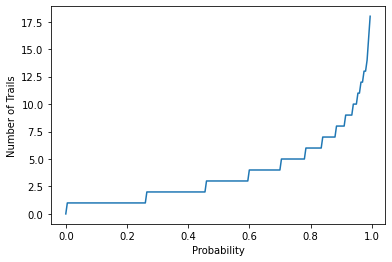

In [14]:
x = []
y = []

for p in range(0,1000,5):
    x.append(p/1000)
    y.append(math.ceil(np.log(1-p/1000)/np.log(1-(0.8**6))))
    
plt.plot(x,y)
plt.xlabel("Probability")
plt.ylabel("Number of Trails")
plt.show()

# 2. Zhang’s method

In [15]:
def get_world_pts(x=7,y=6):
    world_points = np.zeros((x*y,3), np.float32)
    grid=np.mgrid[0:x,0:y].T
    world_points[:,:2]=grid.reshape(-1,2)
    return world_points

def scale(im,scale_percent=0.3):
    width = int(im.shape[1] * scale_percent )
    height = int(im.shape[0] * scale_percent )
    dim = (width, height)
    return dim

def get_images(start=5456,n=15):
    images=[]
    dest=[]
    for i in range(start,start+n):
        images.append('../calibration-data/IMG_' + str(i) + '.JPG')
        dest.append('../images/IMG_'+str(i)+'_wireframe.jpg')
    return images,dest

def Zhang_calibration(world_points,images,objpoints,imgpoints):
    
    for fname in images:
        im=cv2.imread(fname)
        dim = scale(im)
        im = cv2.resize(im, dim, interpolation = cv2.INTER_AREA)
        ret, corners = cv2.findChessboardCorners(im, (8,6))

        if ret: 
            imgpoints.append(corners) #append current image points
            objpoints.append(world_points) 
#             img = cv2.drawChessboardCorners(im, (8,6), corners,ret)
#             cv2.imshow('img',img)
#             cv2.waitKey(1000)
#     cv2.destroyAllWindows()
    return cv2.calibrateCamera(objpoints, imgpoints, dim, None, None)




(1) Performed camera calibration using Zhang’s Method using checkerboard images IMG5456.JPG - IMG5470.JPG

In [16]:
world_points=get_world_pts(8,6)
images,destination=get_images(5456,15)
objpoints=[]
imgpoints=[]
ret, mtx, dist, rvecs, tvecs = Zhang_calibration(world_points,images,objpoints,imgpoints)

print('Reprojection Error:', ret)
print ('\nCamera Calibration Matrix:')
print(mtx)
# print('\nDistortion Parameters:')
# print(dist)
# print('\nRotation:')
# print(rvecs)
# print('\nTranslation:')
# print(tvecs)


Reprojection Error: 0.6918834953780572

Camera Calibration Matrix:
[[4.09090565e+03 0.00000000e+00 9.92907913e+02]
 [0.00000000e+00 4.09765178e+03 4.49180851e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]


In [17]:
def wireframe_overlay(images,objpoints,imgpoints,dest):
    for ind in range(len(images)):
        img_pts, _ = cv2.projectPoints(objpoints[ind], rvecs[ind], tvecs[ind], mtx, dist)
        fig = plt.figure(figsize=(8,8),dpi=80)
        i=0
        for j in range(0,6):
            for k in range(0,8):
                if((i+1)%8!=0):
                    plt.plot([img_pts[i][0][0],img_pts[i+1][0][0]],[img_pts[i][0][1],img_pts[i+1][0][1]],'go-')
                if(j!=5):
                    plt.plot([img_pts[i][0][0],img_pts[i+8][0][0]],[img_pts[i][0][1],img_pts[i+8][0][1]],'go-')
                i+=1
        im = imread(images[ind])
        dim = scale(im)
        im = cv2.resize(im, dim, interpolation = cv2.INTER_AREA)
        plt.imshow(im)
        plt.title(dest[ind])
        plt.savefig(dest[ind])


(2) computed the image points using the camera parameters calculated in the part (1) and a wireframe is overlayed over the actual images and saved them in the images folder.

It is observerd that the alignment of the wireframe overlay with the actual checkboxes depends on how accurate the estimated projection matrix is able to project the points. 

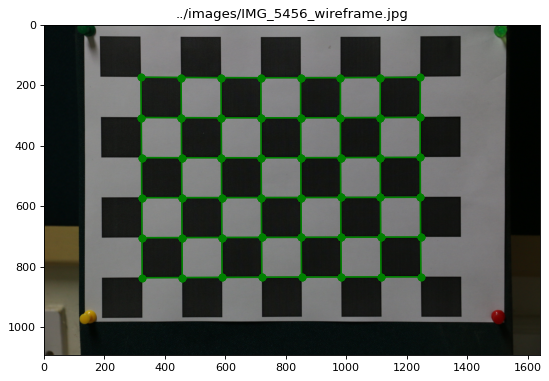

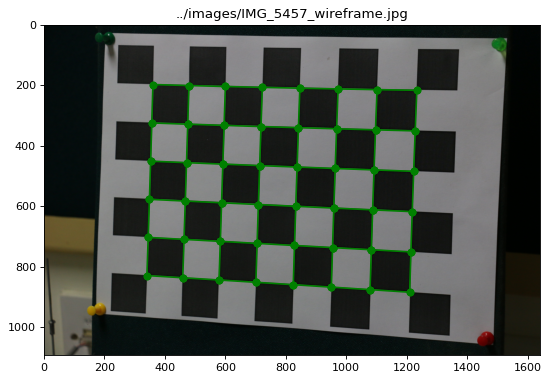

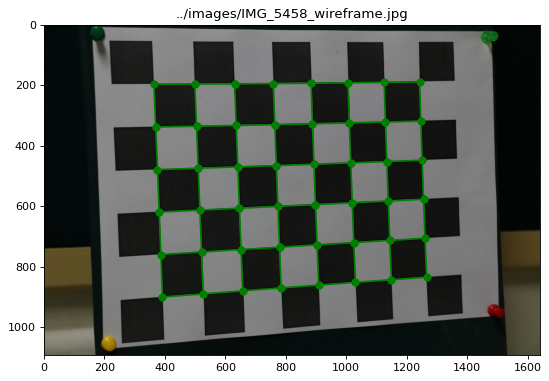

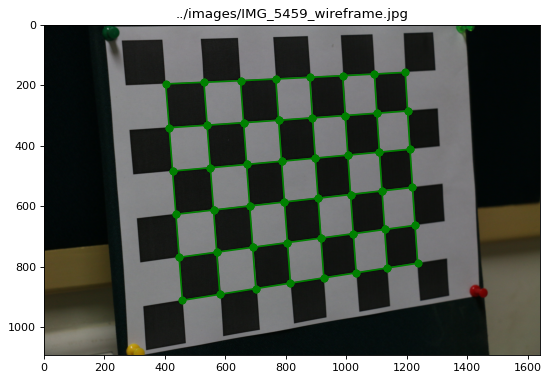

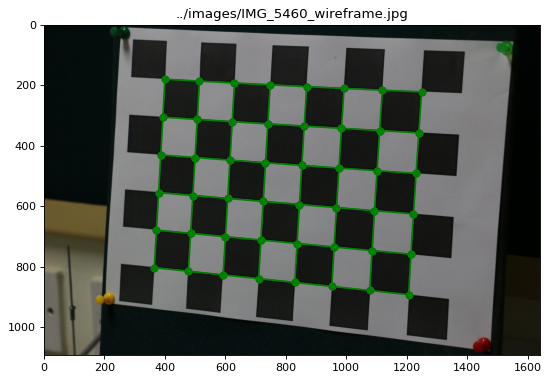

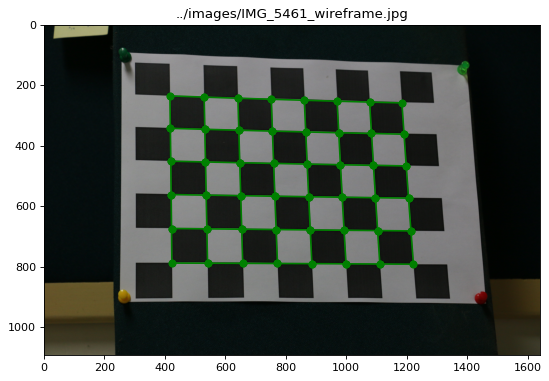

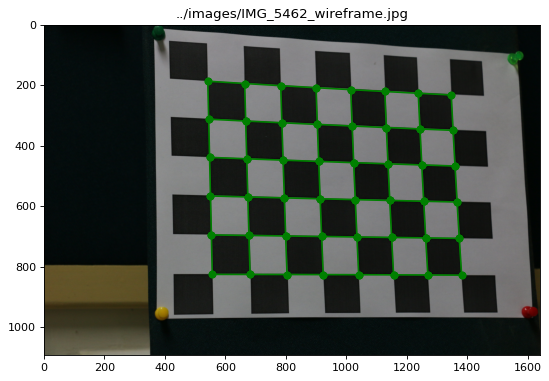

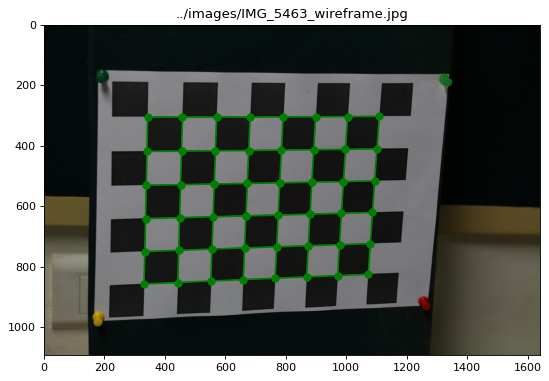

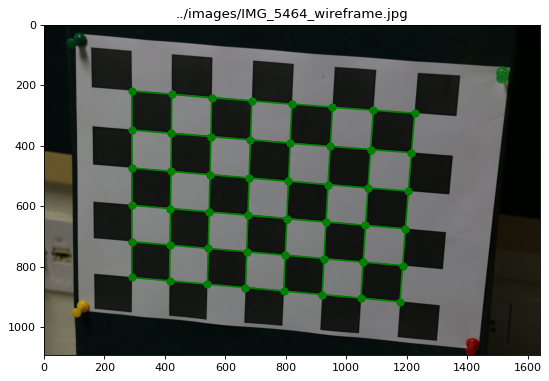

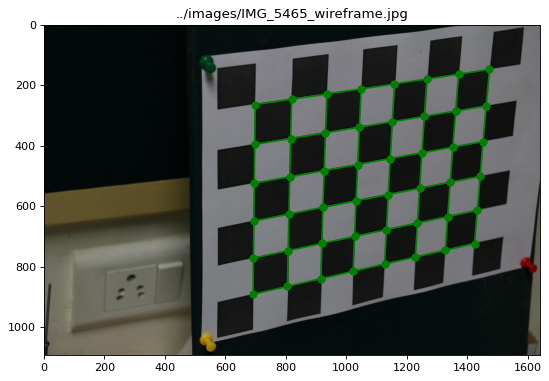

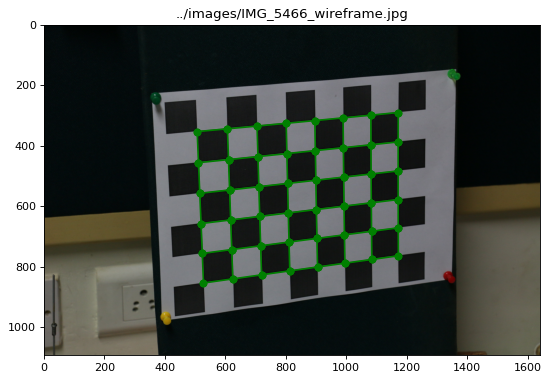

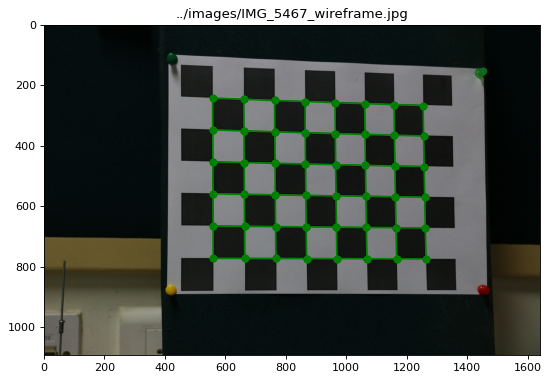

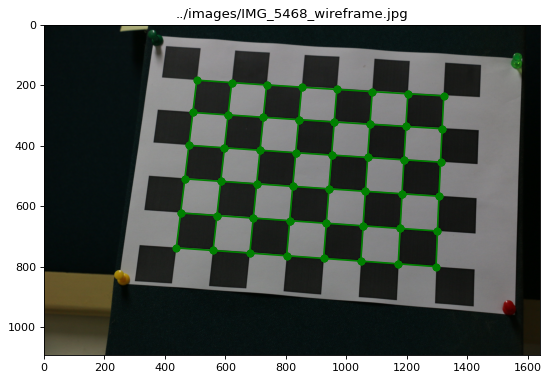

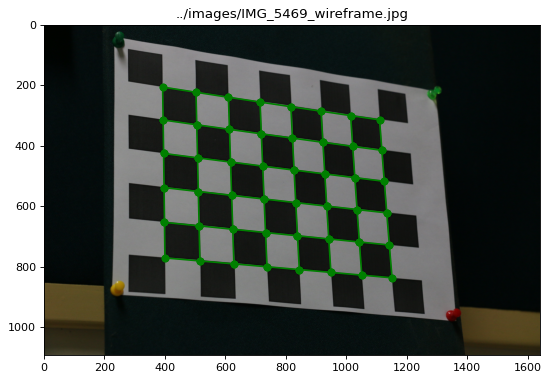

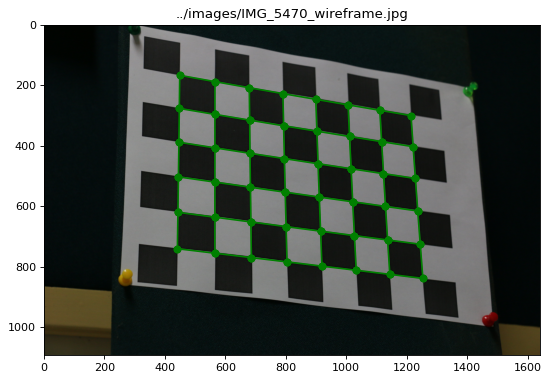

In [18]:
wireframe_overlay(images,objpoints,imgpoints,destination)

# 3. DIY

In [19]:
world_points=[[6,0,0],[6,4,0],[6,13,0],[6,7,0],
              [11,4,0],[11,7,0],[11,13,0],[11,0,0],
              [16,0,0],[16,4,0],[16,7,0],[16,13,0],
              [21,0,1],[21,4,1],[21,7,1],[21,13,1]]
image_points=[[2849,987],[2374,800],[1451,438],[2040,669],
              [2105,1053],[1740,892],[1094,613],[2641,1281],
              [2364,1674],[1751,1375],[1347,1174],[640,828],
              [1897,2377],[1226,1970],[760,1710],[51,1267]]
world_1=np.array(world_points)
image_1=np.array(image_points)

### Using DLT

In [20]:
P,error=calibration(world_1,image_1) 
print("Error:",error)
print("P:\n",P)

Error: 5.502051347194777
P:
 [[-3.09198159e-02 -2.42722881e-02  3.29852699e-03  9.70868475e-01]
 [ 6.55548465e-03 -9.97451163e-03  3.79228325e-02  2.32975613e-01]
 [-7.37883585e-06  3.75379258e-06  7.13010030e-06  3.19660960e-04]]


### Using ransac

In [21]:
P,error=ransac_algo(world_1,image_1)
print(error)


....

iteration  1
error =  1.5833456624109938

....

iteration  2
error =  1.5833456624109938

....

iteration  3
error =  1.5833456624109938

....

iteration  4
error =  1.5833456624109938

....

iteration  5
error =  1.5833456624109938

....

iteration  6
error =  1.5833456624109938

....

iteration  7
error =  1.5833456624109938

....

iteration  8
error =  1.5833456624109938

....

iteration  9
error =  1.5833456624109938

....

iteration  10
error =  1.5833456624109938

....

iteration  11
error =  1.5833456624109938

....

iteration  12
error =  1.5833456624109938

....

iteration  13
error =  1.5833456624109938

....

iteration  14
error =  1.5833456624109938

....

iteration  15
error =  1.5833456624109938

....

iteration  16
error =  0.7401107486106832

....

iteration  17
error =  0.7401107486106832

....

iteration  18
error =  0.7401107486106832

....

iteration  19
error =  0.7401107486106832

....

iteration  20
error =  0.7401107486106832

....

iteration  21
error = 